In [25]:
import numpy as np

In [26]:
class antonForest():

    def __init__(self, t_trees, sample_size, random_state) -> None:
        self.t_trees = t_trees
        self.sample_size = sample_size
        self.random_state = random_state

    def fit(self, X):
        
        self.forest = []
        height_limit = np.ceil(np.log2(self.sample_size))
        
        n_rows = X.shape[0]
        for i in range(self.t_trees):
            
            #if n_rows < self.sample_size:
             #   self.sample_size = n_rows
            #index = self.random_state.choice(range(n_rows), size = self.sample_size, replace = False)
            #This row makes the subsampling and split values random for each run
            index = self.random_state.randint(0, n_rows, self.sample_size)
            #index = np.random.choice(range(n_rows), size=self.sample_size, replace=False)
            #index = np.random.randint(0, n_rows, self.sample_size)
            
            sub_X = X[index]
            
            tree = iTree(0, height_limit)
            tree.fit(sub_X)
            self.forest.append(tree)
            
        return self

    def path_length(self, data):

        edges = []

        for row in data:
            path = []
            for tree in self.forest:
                node = tree.root
                length = 0
                while isinstance(node, DecisionNode):
                    if row[node.q_value] < node.x_value:
                        node = node.left
                    else:
                        node = node.right
                    length += 1
                
                leaf_size = node.size
                path_length = length + c(leaf_size)
                path.append(path_length)
            
            edges.append(path)
        edges = np.array(edges)
        return np.mean(edges, axis = -1)

    def decision_function(self, data):

        average_length = self.path_length(data)
        scores = np.array([np.power(2, -l/c(self.sample_size)) for l in average_length])
        #WARNING fix - and +0.5
        scores = -scores +0.5#+ 0.4775
        return scores

    def predict_from_score(self, scores, threshold):
        return np.array([1 if s >= threshold else 0 for s in scores])

    def predict(self, data, threshold):
        scores = self.decision_function(data)
        prediction = self.predict_from_score(scores, threshold)
        return prediction

In [27]:
class Leaf:

    def __init__(self, size, data) -> None:
        self.size = size
        self.data = data

In [28]:
class DecisionNode:

    def __init__(self, left, right, q_value, x_value) -> None:
        self.left = left
        self.right = right
        self.q_value = q_value
        self.x_value = x_value

In [29]:
class iTree():

    def __init__(self, current_height, height_limit) -> None:
        self.current_height = current_height
        self.heigh_limit = height_limit

    def fit(self, sub_sample):
        
        X = sub_sample
        
        if self.current_height >= self.heigh_limit or X.shape[0] <= 2:
            self.root = Leaf(X.shape[0], X)
            return self.root
        else:
            #Chosing random q value
            n_attributes = X.shape[1]#WARNING changed from 1 to 0
            #print(X.shape)
            q_value = np.random.randint(0, n_attributes)
            #Chosing random x value
            x_value = np.random.uniform(min(X[:, q_value]), max(X[:, q_value]))

            X_left = X[X[:, q_value] < x_value]
            X_right = X[X[:, q_value] >= x_value]

            left_subtree = iTree(self.current_height + 1, self.heigh_limit)
            right_subtree = iTree(self.current_height + 1, self.heigh_limit)

            left_subtree.fit(X_left)
            right_subtree.fit(X_right)

            self.root = DecisionNode(left_subtree.root, right_subtree.root, q_value, x_value)
            self.n_nodes = self.count_nodes(self.root)

            return self.root

    def count_nodes(self, root):
            
        count = 0
        stack = [root]
           
        while stack:
            node = stack.pop()
            count += 1

        if isinstance(node, DecisionNode):
            stack.append(node.right)
            stack.append(node.left)

        return count


Code for testing and running the classes and functions:

In [30]:
from __future__ import division
from __future__ import print_function
from sklearn.ensemble import IsolationForest

import os
import sys
from time import time

# temporary solution for relative imports in case pyod is not installed
# if pyod is installed, no need to use the following line
sys.path.append(
    os.path.abspath(os.path.join(os.path.dirname("__file__"), '..')))

from numpy import percentile
from sklearn.metrics import average_precision_score
import scipy.io
import matplotlib.pyplot as plt

In [31]:
# Define the number of inliers and outliers
n_samples = 200
outliers_fraction = 0.25
clusters_separation = [0]

# Compare given detectors under given settings
# Initialize the data
xx, yy = np.meshgrid(np.linspace(-7, 7, 100), np.linspace(-7, 7, 100))
n_inliers = int((1. - outliers_fraction) * n_samples)
n_outliers = int(outliers_fraction * n_samples)
ground_truth = np.zeros(n_samples, dtype=int)
ground_truth[-n_outliers:] = 1

In [32]:
random_state = np.random.RandomState(42)

[0.03218607765197428, 0.03191893249622675, 0.03244511304639444, 0.03133961511042466, 0.03205566845632137, 0.031353537474015064, 0.03190090964589554, 0.03161013133594983, 0.031564032614968346, 0.03203124328996025]


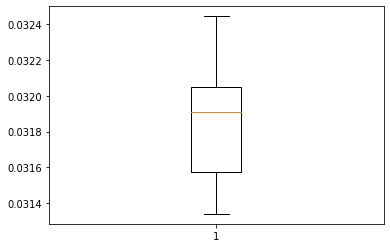

In [33]:
# Fit the models with the generated data and 
# compare model performances
def c(size):
    if size > 2:
        return 2 * (np.log(size-1)+0.5772156649) - 2*(size-1)/size
    if size == 2:
        return 1
    return 0

np.random.seed(42)
clf = antonForest(100, 256, random_state=random_state)
clf_lib = IsolationForest(random_state=random_state)
# Data generation
#X1 = 0.3 * np.random.randn(n_inliers // 2, 2) #Removed offest
#X2 = 0.3 * np.random.randn(n_inliers // 2, 2) #Removed offset
#X = np.r_[X1, X2]
# Add outliers
#X = np.r_[X, np.random.uniform(low=-6, high=6, size=(n_outliers, 2))]

data = scipy.io.loadmat('C:\\Users\\anton\\OneDrive\\Skrivbord\\Thesis_Code\\IsolationForestTinyML\\DatSets\\glass.mat',
                        squeeze_me=False)

enlist = list(data.items())
X = np.array(enlist, dtype=object)
X = np.delete(X, 0, 0)
X = np.delete(X, 0, 0)
X = np.delete(X, 0, 0)
X = np.delete(X, 0, 1)

y_true = np.empty([1,0], dtype=int)

#print(X[1][0][0])
k = 0
while k < len(X[1][0]):
    y_true = np.append(y_true, int(X[1][0][k]))
    k += 1

X = X[0][0]
#print(X[0][0])
# Fit the model
#plt.figure(figsize=(15, 12))
# fit the data and tag outliers
p = 0
aps = []
aps_lib = []
while p < 10:
    clf.fit(X)
    clf_lib.fit(X)
    #WARNING put +1
    scores_pred = clf.decision_function(X) * 1
    scores_pred_lib = clf_lib.decision_function(X) * 1 

    threshold = percentile(scores_pred, 100 * outliers_fraction)
    threshold_lib = percentile(scores_pred_lib, 100 * outliers_fraction)

    y_pred = clf.predict(X, threshold) * -1
    y_pred = (y_pred + 1) #/ 2

    y_pred_lib = clf_lib.predict(X) * -1
    y_pred_lib = (y_pred_lib + 1) / 2

    aps.append(average_precision_score(y_true, scores_pred))
    aps_lib.append(average_precision_score(y_true, scores_pred_lib))
    p += 1
#n_errors = (y_pred != ground_truth).sum()
# plot the levels lines and the points

#WARNING +1
#Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()]) * 1
#Z = Z.reshape(xx.shape)
#plt.figure(figsize=[10,10])
#subplot = plt.subplot(2, 2, 1)
#subplot.contourf(xx, yy, Z, levels=np.linspace(Z.min(), threshold, 7),
#                    cmap=plt.cm.Blues_r)
#a = subplot.contour(xx, yy, Z, levels=[threshold], #Removed - in front of threshold, since -score
#                    linewidths=2, colors='red')
#subplot.contourf(xx, yy, Z, levels=[threshold, Z.max()],
#                    colors='orange')
#b = subplot.scatter(X[:-n_outliers, 0], X[:-n_outliers, 1], c='white',
#                    s=20, edgecolor='k')
#c = subplot.scatter(X[-n_outliers:, 0], X[-n_outliers:, 1], c='black',
#                    s=20, edgecolor='k')
#subplot.axis('tight')
#subplot.set_xlabel("%d. %s (errors: %d)" % (1, "Isolation Forest", n_errors))
#subplot.set_xlim((-7, 7))
#subplot.set_ylim((-7, 7))
#plt.subplots_adjust(0.04, 0.1, 0.96, 0.94, 0.1, 0.26)
#plt.suptitle("Outlier detection")
#plt.show()
plt.boxplot(aps)
print(aps)